In [ ]:
# pip install dash

In [1]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras import layers
import matplotlib.pyplot as plt
import re

import nltk
from nltk.corpus import stopwords
import string
from  nltk import FreqDist
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.collocations import *
# nltk.download('wordnet')
from nltk import word_tokenize, FreqDist

from spacy import displacy
import spacy
from tqdm import tqdm

tqdm.pandas()
from spacytextblob.spacytextblob import SpacyTextBlob

nlp = spacy.load('en_core_web_sm')
nlp.add_pipe('spacytextblob')

import plotly.graph_objects as go
import plotly.express as px

from dateutil import rrule
import datetime as datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta
import time
currentDate = datetime.datetime.now()

Using TensorFlow backend.


In [2]:
#Importing Webscraped data from Reddit and twitter talking about TSLA stock(60 months)
df = pd.read_csv('static_dataset.csv')

In [3]:
#Shape of the Dataset
print("Shape of data=>",df.shape)
df.head(5)

Shape of data=> (10193, 6)


Unnamed: 0                                       post        date  \
0           0                                   $BBBY DD  2021-06-02   
1           1     Here comes the sun turururu $RUN $TSLA  2021-06-02   
2           2                  $Run $Tsla f*** the suits  2021-06-02   
3           3  B.A.R.S - The Ultimate Meme Portfolio 🚀🚀🚀  2021-06-01   
4           4                              (TSLA) vs (F)  2021-06-01   

                                       spacy  sentiment  subjectivity  
0                                   $BBBY DD        0.0           0.0  
1     Here comes the sun turururu $RUN $TSLA        0.0           0.0  
2                  $Run $Tsla f*** the suits        0.0           0.0  
3  B.A.R.S - The Ultimate Meme Portfolio 🚀🚀🚀        0.0           1.0  
4                              (TSLA) vs (F)        0.0           0.0

In [4]:
df=df.drop(['Unnamed: 0'], axis=1)

In [5]:
#Checking for Nulls
df.isnull().sum()

post            0
date            0
spacy           0
sentiment       0
subjectivity    0
dtype: int64

In [6]:
# taking a look at 5 random posts
for index,text in enumerate(df['post'][35:40]):
  print('Posts %d:\n'%(index+1),text)

Posts 1:
 $SOS clean and green till Elon gets a ring. WE SHALL RISE
Posts 2:
 Is $SPCE the next $GME.
Posts 3:
 F IS SUPER UNDERVALUED
Posts 4:
 $GOGO is a Starlink play
Posts 5:
 WOW! Look what is happening with Ford (F)! It have reached 15 years high and not stoping, I think it will be one of those stocks that get tremendous momentum! Let's watch!


In [7]:
# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
  def replace(match):
    return contractions_dict[match.group(0)]
  return contractions_re.sub(replace, text)

# Expanding Contractions in the reviews
df['post']=df['post'].apply(lambda x:expand_contractions(x))

In [8]:
# taking a look at 5 posts after expanding contrations
for index,text in enumerate(df['post'][35:40]):
  print('Posts %d:\n'%(index+1),text)

Posts 1:
 $SOS clean and green till Elon gets a ring. WE SHALL RISE
Posts 2:
 Is $SPCE the next $GME.
Posts 3:
 F IS SUPER UNDERVALUED
Posts 4:
 $GOGO is a Starlink play
Posts 5:
 WOW! Look what is happening with Ford (F)! It have reached 15 years high and not stoping, I think it will be one of those stocks that get tremendous momentum! Let is watch!


In [9]:
#Converting the posts into lower case for the purposes of NLP
df['post']=df['post'].apply(lambda x: x.lower())

In [10]:
#Removing numbers and words containing numbers
df['post']=df['post'].apply(lambda x: re.sub('\w*\d\w*','', x))

In [11]:
#Removing punctuation
df['post']=df['post'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))

In [12]:
#Removing extra spaces
df['post']=df['post'].apply(lambda x: re.sub(' +',' ',x))

In [13]:
# taking a look at 5 random posts
for index,text in enumerate(df['post'][0:5]):
  print('Posts %d:\n'%(index+1),text)

Posts 1:
 bbby dd
Posts 2:
 here comes the sun turururu run tsla
Posts 3:
 run tsla f the suits
Posts 4:
 bars the ultimate meme portfolio 🚀🚀🚀
Posts 5:
 tsla vs f


## NLP:

In [14]:
#Lemmatizing the tokens and removing stopwords
df['lemmatized']=df['post'].apply(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]))

In [15]:
df_grouped=df[['post','lemmatized']].groupby(by='post').agg(lambda x:' '.join(x))
df_grouped.head()

lemmatized
post                                                                              
                                                                                  
nio will be worthless in a few years                          nio worthless year
 a day after a day recently only been trading f...    day day recently trade month
 a pop long tsla                                                     pop long tsla
 and a dream                                                                 dream

In [16]:
from sklearn.feature_extraction.text import CountVectorizer

In [17]:
#Created Document tearm matrix
cv=CountVectorizer(analyzer='word')
data=cv.fit_transform(df_grouped['lemmatized'])
df_dtm = pd.DataFrame(data.toarray(), columns=cv.get_feature_names())
df_dtm.index=df_grouped.index
df_dtm.head(3)

aa  aaa  aaaaaaaaand  \
post                                                                       
                                                     0    0            0   
nio will be worthless in a few years                0    0            0   
 a day after a day recently only been trading f...   0    0            0   

                                                    aaaaaaand  aaand  aal  \
post                                                                        
                                                            0      0    0   
nio will be worthless in a few years                       0      0    0   
 a day after a day recently only been trading f...          0      0    0   

                                                    aapl  aapltsla  aaxn  ab  \
post                                                                           
                                                       0         0     0   0   
nio will be worthless in a few years                  0         0     0   0   
 a day after a day recently only been trading f...     0         0     0   0   

                                                    ...  𝐄𝐋𝐄𝐂𝐓𝐑𝐄𝐊  𝐇𝐀𝐒  𝐈𝐍  \
post                                                ...                      
                                                    ...         0    0   0   
nio will be worthless in a few years               ...         0    0   0   
 a day after a day recently only been trading f...  ...         0    0   0   

                                                    𝐈𝐍𝐂𝐑𝐄𝐀𝐒𝐄𝐃  𝐌𝐎𝐃𝐄𝐋  𝐎𝐅  \
post                                                                       
                                                            0      0   0   
nio will be worthless in a few years                       0      0   0   
 a day after a day recently only been trading f...          0      0   0   

                                                    𝐏𝐑𝐈𝐂𝐄  𝐓𝐄𝐒𝐋𝐀  𝐓𝐇𝐄  𝐔𝐒  
post                                                                       
                                                        0      0    0   0  
nio will be worthless in a few years                   0      0    0   0  
 a day after a day recently only been trading f...      0      0    0   0  

[3 rows x 8014 columns]

In [18]:
df_dtm.astype('float')

aa  aaa  aaaaaaaaand  \
post                                                                        
                                                    0.0  0.0          0.0   
nio will be worthless in a few years               0.0  0.0          0.0   
 a day after a day recently only been trading f...  0.0  0.0          0.0   
 a pop long tsla                                    0.0  0.0          0.0   
 and a dream                                        0.0  0.0          0.0   
...                                                 ...  ...          ...   
🤑all in tsla🤑                                       0.0  0.0          0.0   
🤗 this made my day thanks for the shoutout and ...  0.0  0.0          0.0   
🦍 turn tsla to more 🍌🍌🍌                             0.0  0.0          0.0   
🦠poll time🦠 monday march                            0.0  0.0          0.0   
🦠poll time🦠monday march                             0.0  0.0          0.0   

                                                    aaaaaaand  aaand  aal  \
post                                                                        
                                                          0.0    0.0  0.0   
nio will be worthless in a few years                     0.0    0.0  0.0   
 a day after a day recently only been trading f...        0.0    0.0  0.0   
 a pop long tsla                                          0.0    0.0  0.0   
 and a dream                                              0.0    0.0  0.0   
...                                                       ...    ...  ...   
🤑all in tsla🤑                                             0.0    0.0  0.0   
🤗 this made my day thanks for the shoutout and ...        0.0    0.0  0.0   
🦍 turn tsla to more 🍌🍌🍌                                   0.0    0.0  0.0   
🦠poll time🦠 monday march                                  0.0    0.0  0.0   
🦠poll time🦠monday march                                   0.0    0.0  0.0   

                                                    aapl  aapltsla  aaxn   ab  \
post                                                                            
                                                     0.0       0.0   0.0  0.0   
nio will be worthless in a few years                0.0       0.0   0.0  0.0   
 a day after a day recently only been trading f...   0.0       0.0   0.0  0.0   
 a pop long tsla                                     0.0       0.0   0.0  0.0   
 and a dream                                         0.0       0.0   0.0  0.0   
...                                                  ...       ...   ...  ...   
🤑all in tsla🤑                                        0.0       0.0   0.0  0.0   
🤗 this made my day thanks for the shoutout and ...   0.0       0.0   0.0  0.0   
🦍 turn tsla to more 🍌🍌🍌                              0.0       0.0   0.0  0.0   
🦠poll time🦠 monday march                             0.0       0.0   0.0  0.0   
🦠poll time🦠monday march                              0.0       0.0   0.0  0.0   

                                                    ...  𝐄𝐋𝐄𝐂𝐓𝐑𝐄𝐊  𝐇𝐀𝐒   𝐈𝐍  \
post                                                ...                       
                                                    ...       0.0  0.0  0.0   
nio will be worthless in a few years               ...       0.0  0.0  0.0   
 a day after a day recently only been trading f...  ...       0.0  0.0  0.0   
 a pop long tsla                                    ...       0.0  0.0  0.0   
 and a dream                                        ...       0.0  0.0  0.0   
...                                                 ...       ...  ...  ...   
🤑all in tsla🤑                                       ...       0.0  0.0  0.0   
🤗 this made my day thanks for the shoutout and ...  ...       0.0  0.0  0.0   
🦍 turn tsla to more 🍌🍌🍌                             ...       0.0  0.0  0.0   
🦠poll time🦠 monday march                            ...       0.0  0.0  0.0   
🦠poll time🦠monday march                        

In [19]:
df.head()

post        date  \
0                               bbby dd  2021-06-02   
1  here comes the sun turururu run tsla  2021-06-02   
2                  run tsla f the suits  2021-06-02   
3  bars the ultimate meme portfolio 🚀🚀🚀  2021-06-01   
4                             tsla vs f  2021-06-01   

                                       spacy  sentiment  subjectivity  \
0                                   $BBBY DD        0.0           0.0   
1     Here comes the sun turururu $RUN $TSLA        0.0           0.0   
2                  $Run $Tsla f*** the suits        0.0           0.0   
3  B.A.R.S - The Ultimate Meme Portfolio 🚀🚀🚀        0.0           1.0   
4                              (TSLA) vs (F)        0.0           0.0   

                          lemmatized  
0                            bbby dd  
1         come sun turururu run tsla  
2                    run tsla f suit  
3  bar ultimate meme portfolio 🚀 🚀 🚀  
4                          tsla vs f

In [20]:
#Showing posts with the higest sentiment
print("3 Post with Highest Sentiment:")
for index,post in enumerate(df.iloc[df['sentiment'].sort_values(ascending=False)[:3].index]['post']):
  print('Post {}:\n'.format(index+1),post)

3 Post with Highest Sentiment:
Post 1:
 what ev stock is the best bet nio or arvl
Post 2:
 ⚠️breaking⚠️ tesla china 🇨🇳 sold china made model y in feb an impressive growth vs jan tsla httpstco
Post 3:
 tsla earnings report best quarter ever


In [21]:
#Post with the lowest sentiment
print("3 Post with Lowest Sentiment:")
for index,post in enumerate(df.iloc[df['sentiment'].sort_values(ascending=True)[:3].index]['post']):
  print('Post {}:\n'.format(index+1),post)

3 Post with Lowest Sentiment:
Post 1:
 i have buying power on robinhood what terrible position can i take on tsla before earnings
Post 2:
 to all the miserable bastards that missed the tsla rocket here is what your gainz could have looked like
Post 3:
 ohh stock market you are a cruel mistress


In [22]:
df = df.groupby(['date']).mean().sort_values(by='date', ascending=False)

In [23]:
df.index.names = ['Date']
df.head()

sentiment  subjectivity
Date                               
2021-06-02   0.000000      0.000000
2021-06-01   0.146875      0.625000
2021-05-31   0.016667      0.288542
2021-05-30   0.147222      0.443981
2021-05-29   0.006905      0.290278

In [24]:
tick = web.DataReader('AMC', data_source='yahoo', start=str((currentDate - relativedelta(months=72)).date()), end=str(currentDate.date()))

In [25]:
tick

High        Low       Open      Close       Volume  Adj Close
Date                                                                          
2015-06-10  28.590000  28.080000  28.590000  28.219999     232600.0  21.077862
2015-06-11  28.809999  28.020000  28.070000  28.570000     158300.0  21.339277
2015-06-12  28.549999  28.150000  28.420000  28.469999     160800.0  21.264591
2015-06-15  28.930000  27.900000  28.219999  28.870001     445900.0  21.563354
2015-06-16  28.879999  28.420000  28.850000  28.469999     230200.0  21.264591
...               ...        ...        ...        ...          ...        ...
2021-06-04  57.480000  46.040001  48.790001  47.910000  332019000.0  47.910000
2021-06-07  59.680000  51.500000  52.380001  55.000000  349094900.0  55.000000
2021-06-08  60.619999  52.770000  57.160000  55.049999  214490300.0  55.049999
2021-06-09  53.389999  48.119999  52.200001  49.340000  149113000.0  49.340000
2021-06-10  51.450001  39.709999  47.930000  42.810001  221607552.0  42.810001

[1512 rows x 6 columns]

In [26]:
df = tick.join(df)

In [27]:
df

High        Low       Open      Close       Volume  \
Date                                                                  
2015-06-10  28.590000  28.080000  28.590000  28.219999     232600.0   
2015-06-11  28.809999  28.020000  28.070000  28.570000     158300.0   
2015-06-12  28.549999  28.150000  28.420000  28.469999     160800.0   
2015-06-15  28.930000  27.900000  28.219999  28.870001     445900.0   
2015-06-16  28.879999  28.420000  28.850000  28.469999     230200.0   
...               ...        ...        ...        ...          ...   
2021-06-04  57.480000  46.040001  48.790001  47.910000  332019000.0   
2021-06-07  59.680000  51.500000  52.380001  55.000000  349094900.0   
2021-06-08  60.619999  52.770000  57.160000  55.049999  214490300.0   
2021-06-09  53.389999  48.119999  52.200001  49.340000  149113000.0   
2021-06-10  51.450001  39.709999  47.930000  42.810001  221607552.0   

            Adj Close  sentiment  subjectivity  
Date                                            
2015-06-10  21.077862        NaN           NaN  
2015-06-11  21.339277        NaN           NaN  
2015-06-12  21.264591        NaN           NaN  
2015-06-15  21.563354        NaN           NaN  
2015-06-16  21.264591        NaN           NaN  
...               ...        ...           ...  
2021-06-04  47.910000        NaN           NaN  
2021-06-07  55.000000        NaN           NaN  
2021-06-08  55.049999        NaN           NaN  
2021-06-09  49.340000        NaN           NaN  
2021-06-10  42.810001        NaN           NaN  

[1512 rows x 8 columns]

In [28]:
df['Target'] = np.append(df['Close'].iloc[1:].values, [np.nan])
df

High        Low       Open      Close       Volume  \
Date                                                                  
2015-06-10  28.590000  28.080000  28.590000  28.219999     232600.0   
2015-06-11  28.809999  28.020000  28.070000  28.570000     158300.0   
2015-06-12  28.549999  28.150000  28.420000  28.469999     160800.0   
2015-06-15  28.930000  27.900000  28.219999  28.870001     445900.0   
2015-06-16  28.879999  28.420000  28.850000  28.469999     230200.0   
...               ...        ...        ...        ...          ...   
2021-06-04  57.480000  46.040001  48.790001  47.910000  332019000.0   
2021-06-07  59.680000  51.500000  52.380001  55.000000  349094900.0   
2021-06-08  60.619999  52.770000  57.160000  55.049999  214490300.0   
2021-06-09  53.389999  48.119999  52.200001  49.340000  149113000.0   
2021-06-10  51.450001  39.709999  47.930000  42.810001  221607552.0   

            Adj Close  sentiment  subjectivity     Target  
Date                                                       
2015-06-10  21.077862        NaN           NaN  28.570000  
2015-06-11  21.339277        NaN           NaN  28.469999  
2015-06-12  21.264591        NaN           NaN  28.870001  
2015-06-15  21.563354        NaN           NaN  28.469999  
2015-06-16  21.264591        NaN           NaN  28.010000  
...               ...        ...           ...        ...  
2021-06-04  47.910000        NaN           NaN  55.000000  
2021-06-07  55.000000        NaN           NaN  55.049999  
2021-06-08  55.049999        NaN           NaN  49.340000  
2021-06-09  49.340000        NaN           NaN  42.810001  
2021-06-10  42.810001        NaN           NaN        NaN  

[1512 rows x 9 columns]

In [29]:
df = df.drop(df.index[-3:])
df

High        Low       Open      Close       Volume  \
Date                                                                  
2015-06-10  28.590000  28.080000  28.590000  28.219999     232600.0   
2015-06-11  28.809999  28.020000  28.070000  28.570000     158300.0   
2015-06-12  28.549999  28.150000  28.420000  28.469999     160800.0   
2015-06-15  28.930000  27.900000  28.219999  28.870001     445900.0   
2015-06-16  28.879999  28.420000  28.850000  28.469999     230200.0   
...               ...        ...        ...        ...          ...   
2021-06-01  33.529999  28.530001  31.889999  32.040001  508694600.0   
2021-06-02  72.620003  35.590000  37.520000  62.549999  766462500.0   
2021-06-03  68.800003  37.660000  58.099998  51.340000  598142200.0   
2021-06-04  57.480000  46.040001  48.790001  47.910000  332019000.0   
2021-06-07  59.680000  51.500000  52.380001  55.000000  349094900.0   

            Adj Close  sentiment  subjectivity     Target  
Date                                                       
2015-06-10  21.077862        NaN           NaN  28.570000  
2015-06-11  21.339277        NaN           NaN  28.469999  
2015-06-12  21.264591        NaN           NaN  28.870001  
2015-06-15  21.563354        NaN           NaN  28.469999  
2015-06-16  21.264591        NaN           NaN  28.010000  
...               ...        ...           ...        ...  
2021-06-01  32.040001   0.146875         0.625  62.549999  
2021-06-02  62.549999   0.000000         0.000  51.340000  
2021-06-03  51.340000        NaN           NaN  47.910000  
2021-06-04  47.910000        NaN           NaN  55.000000  
2021-06-07  55.000000        NaN           NaN  55.049999  

[1509 rows x 9 columns]

In [30]:
df = df.fillna(df.mean())

In [31]:
df['% Change'] = df['Close'].pct_change()*100

In [32]:
df = df.dropna()

In [33]:
df.isna().sum()

High            0
Low             0
Open            0
Close           0
Volume          0
Adj Close       0
sentiment       0
subjectivity    0
Target          0
% Change        0
dtype: int64

In [34]:
df.reset_index(level=0, inplace=True)

In [35]:
# pip install sweetviz --user
import sweetviz as sv

                                             |          | [  0%]   00:00 -> (? left)


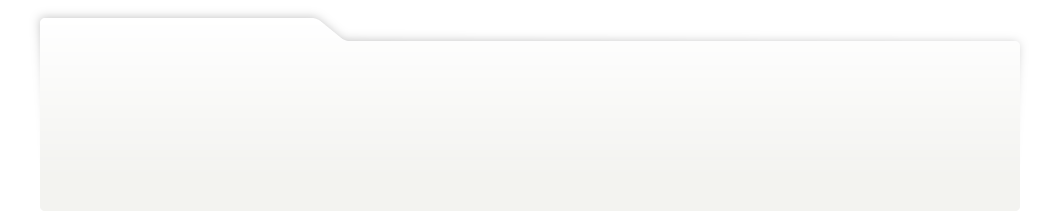
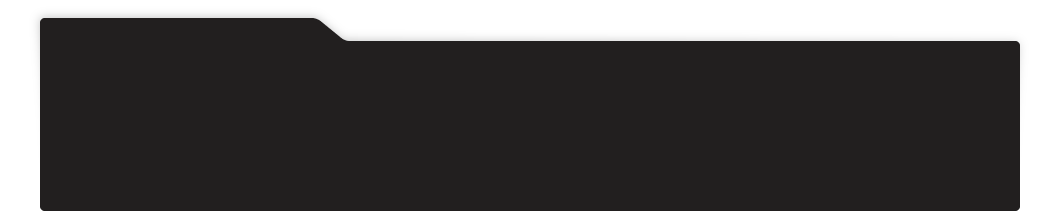
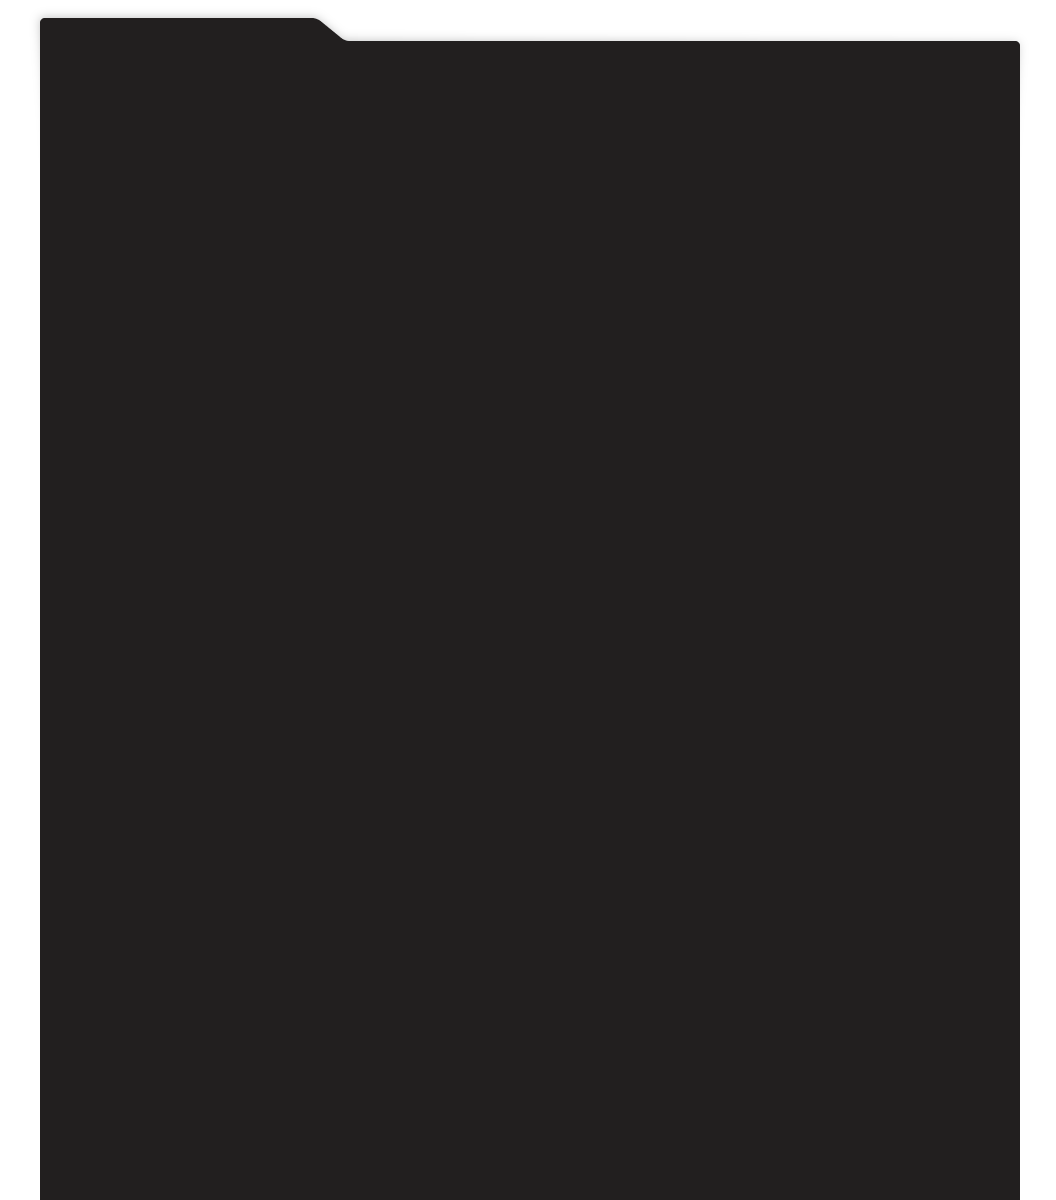
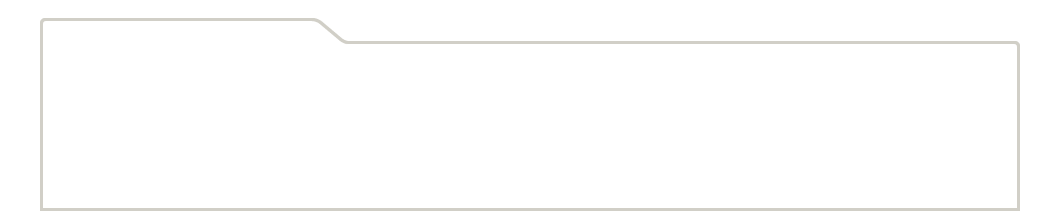
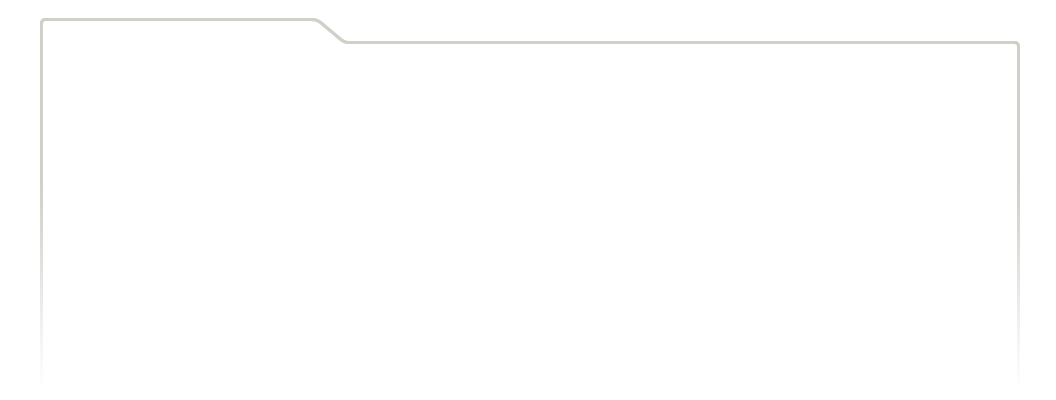
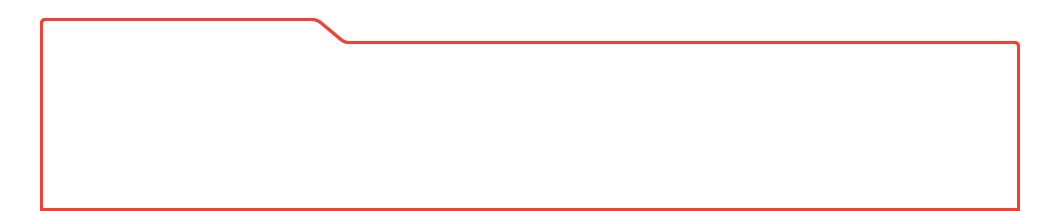
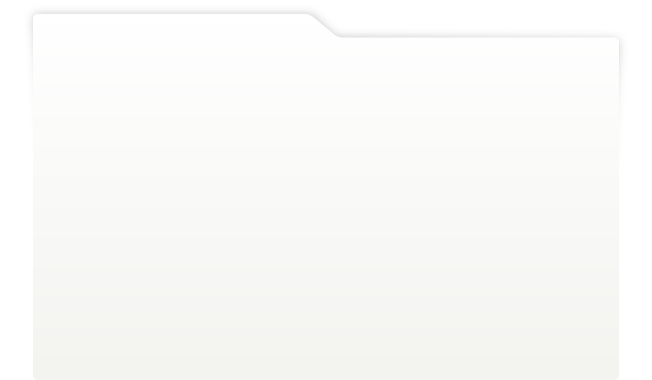
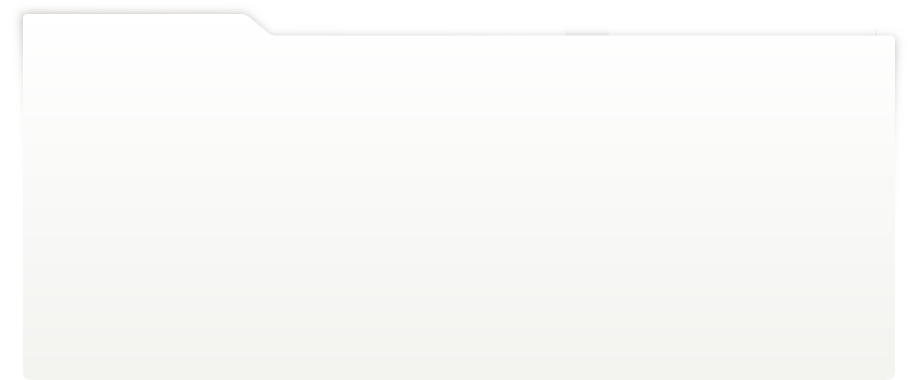
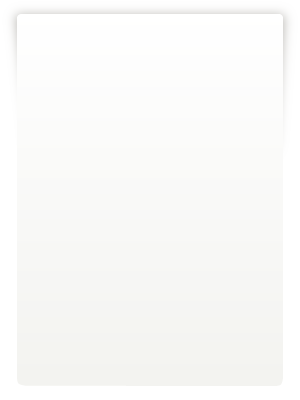
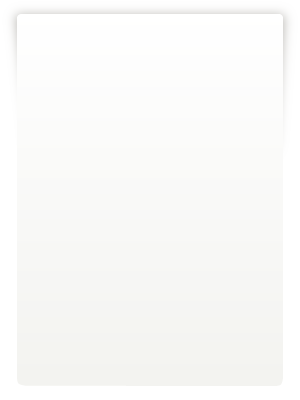
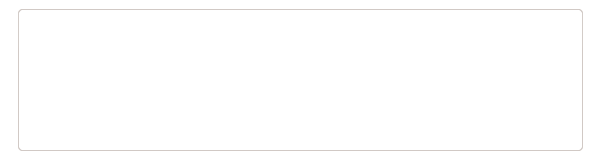
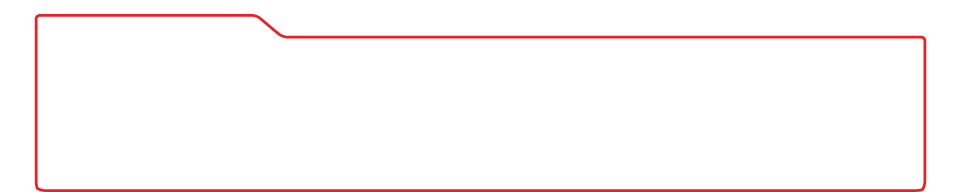
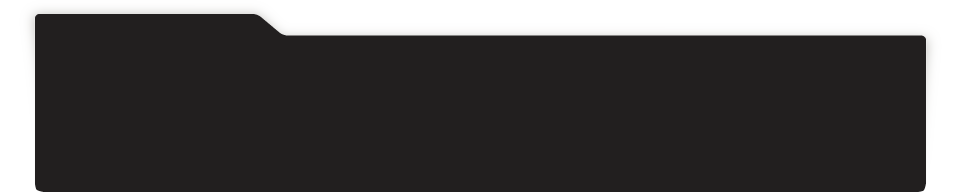
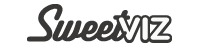
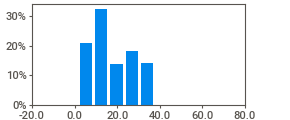
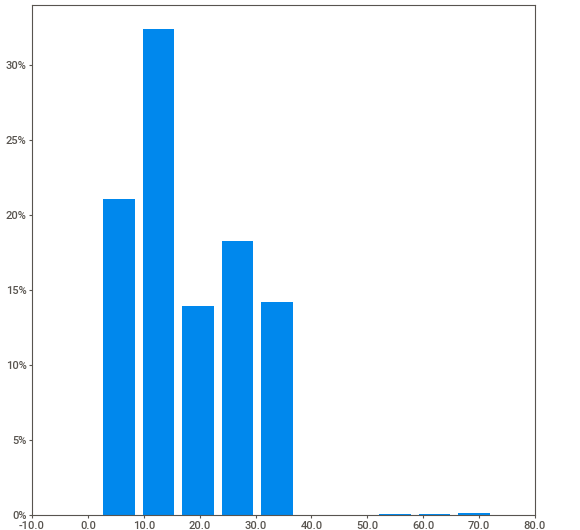
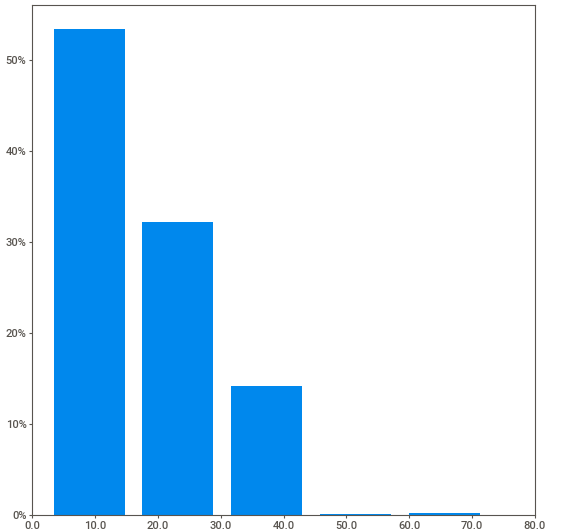
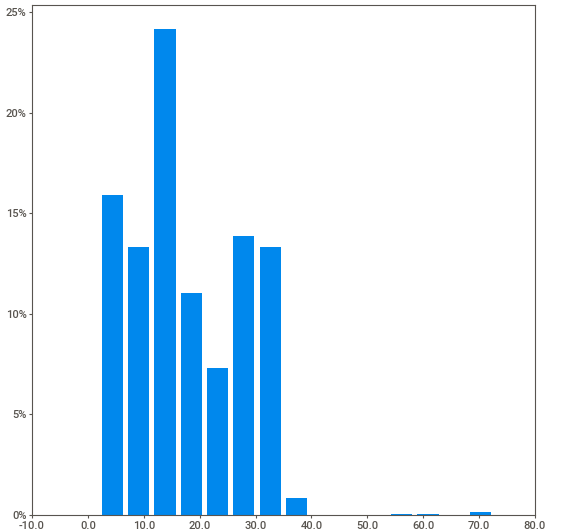
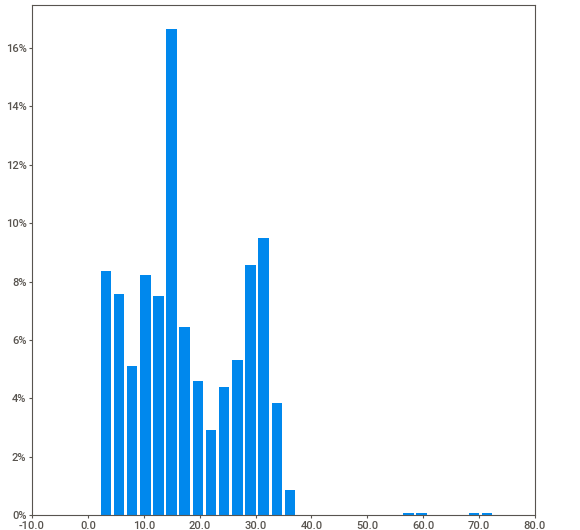
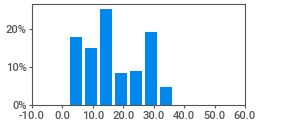
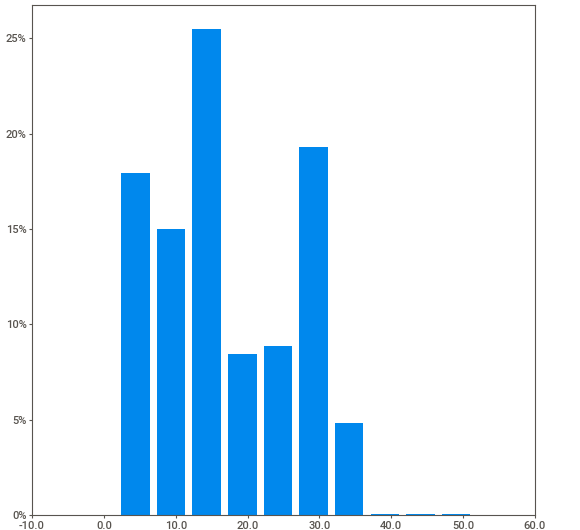
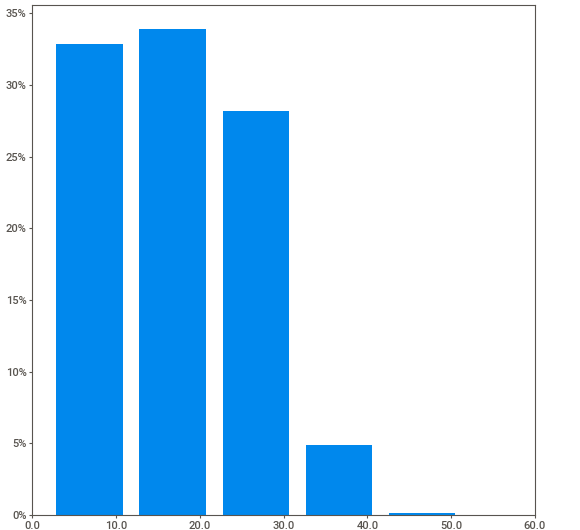
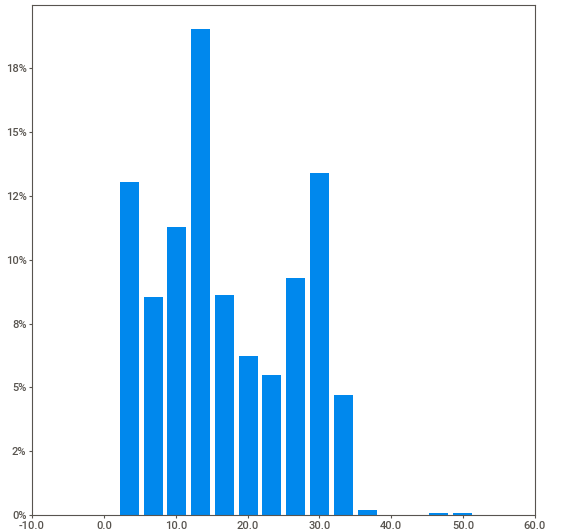
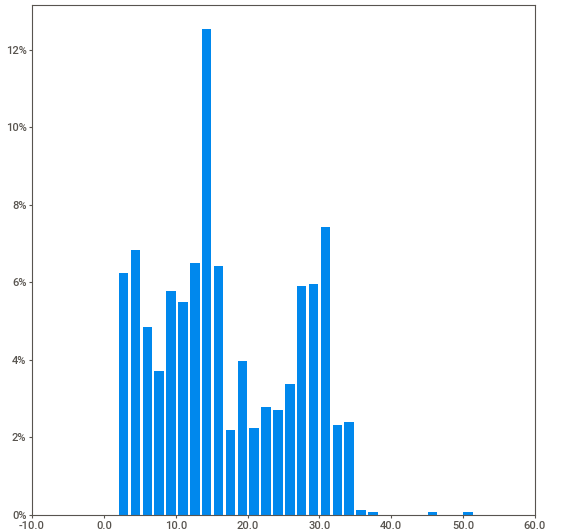
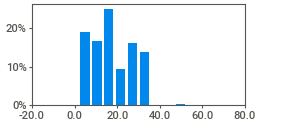
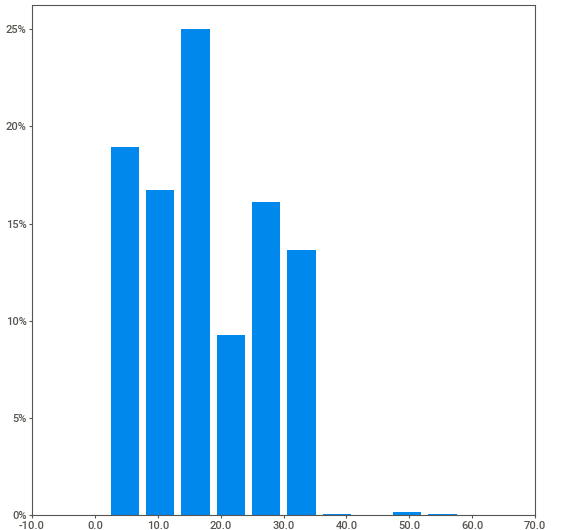
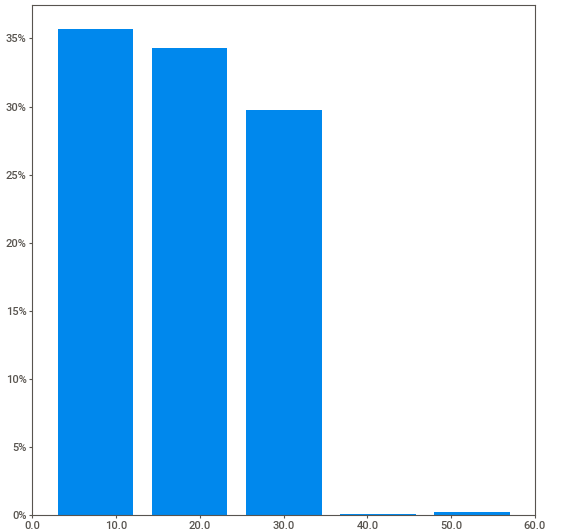
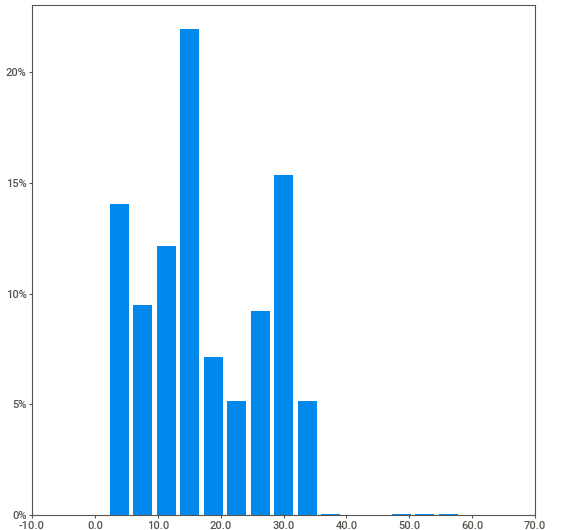
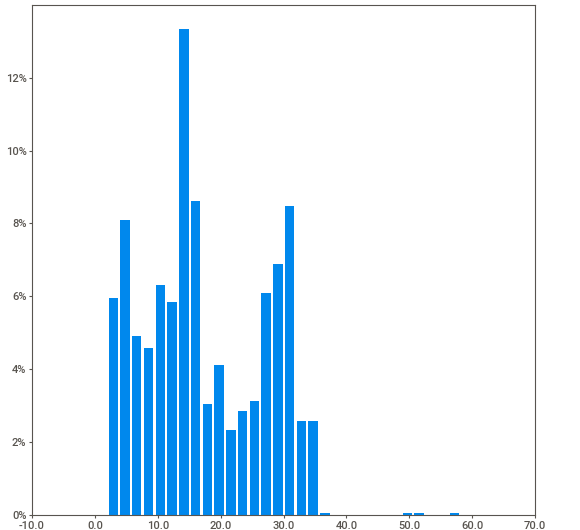
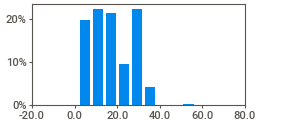
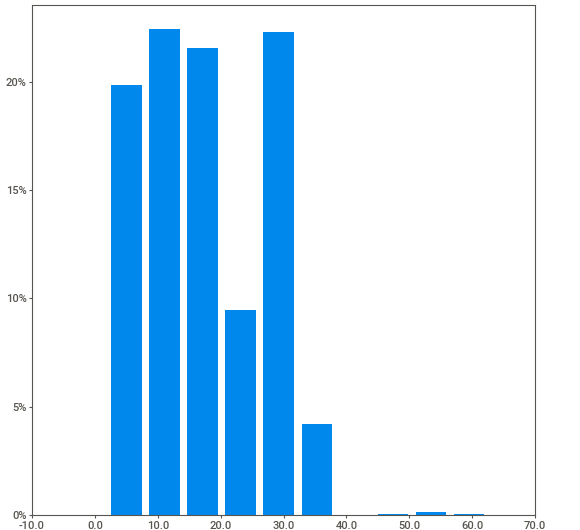
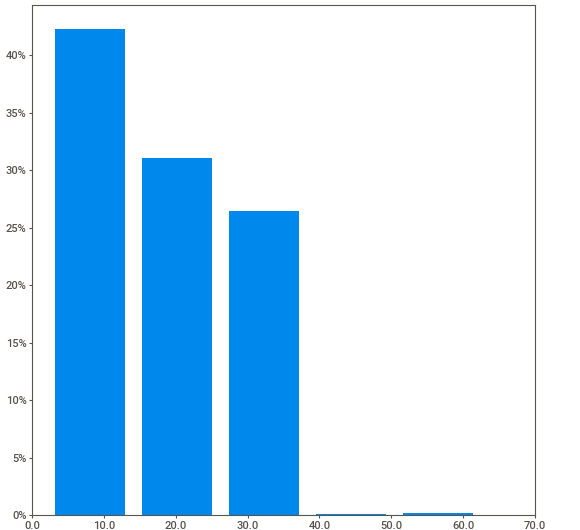
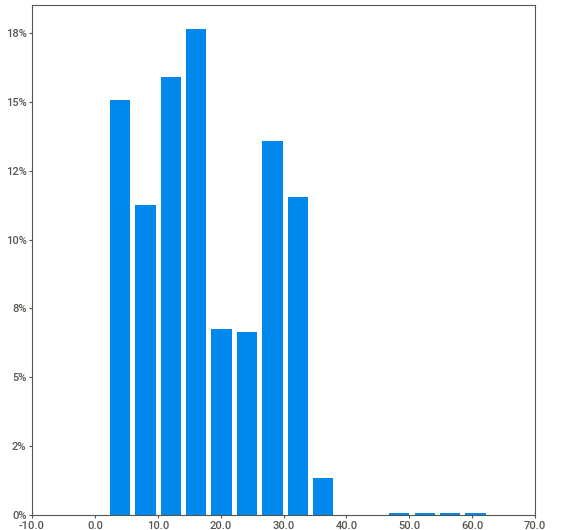
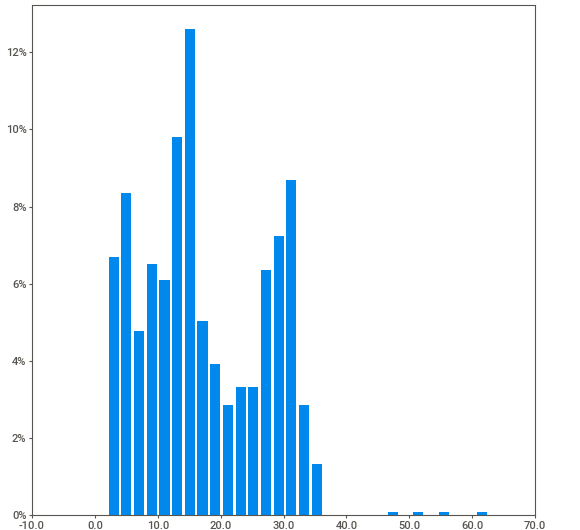
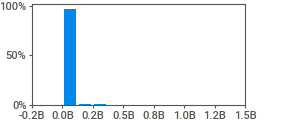
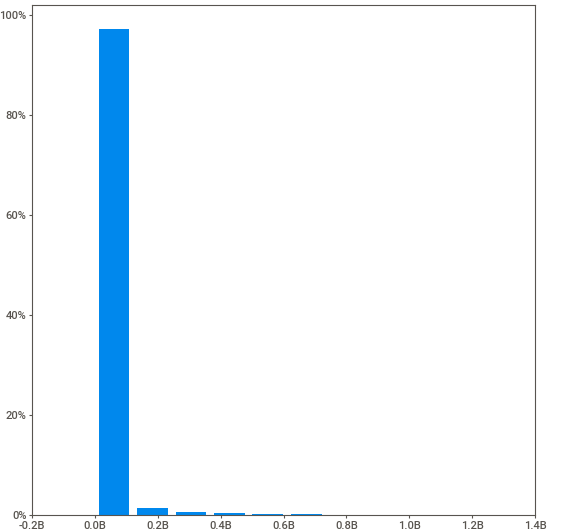
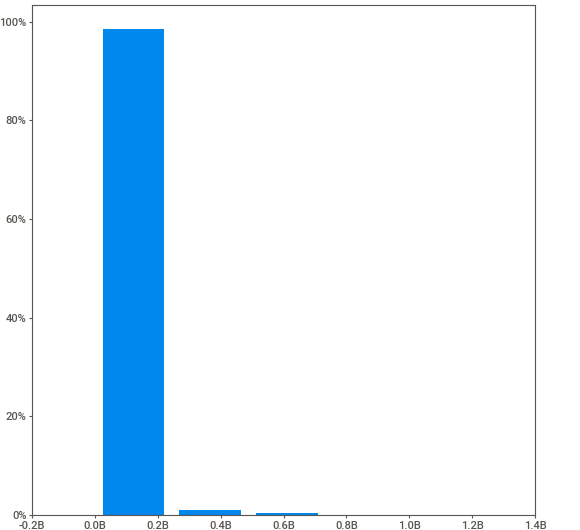
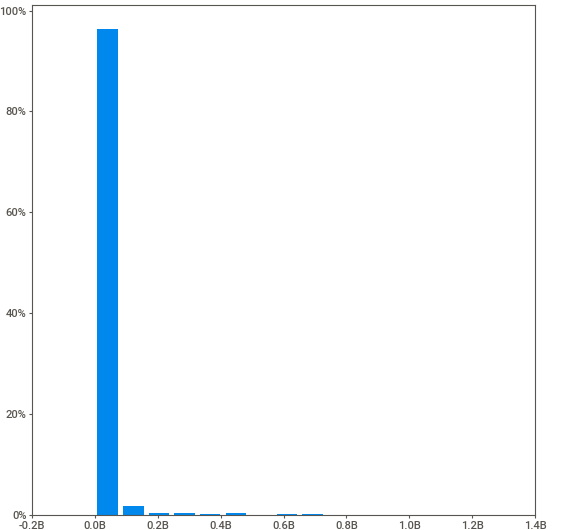
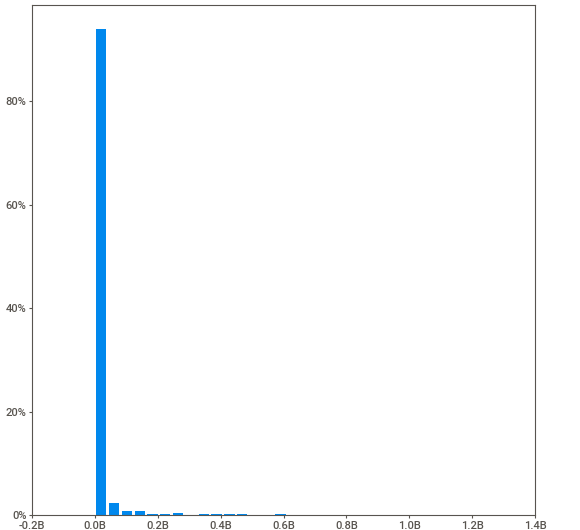
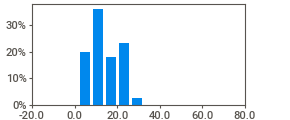
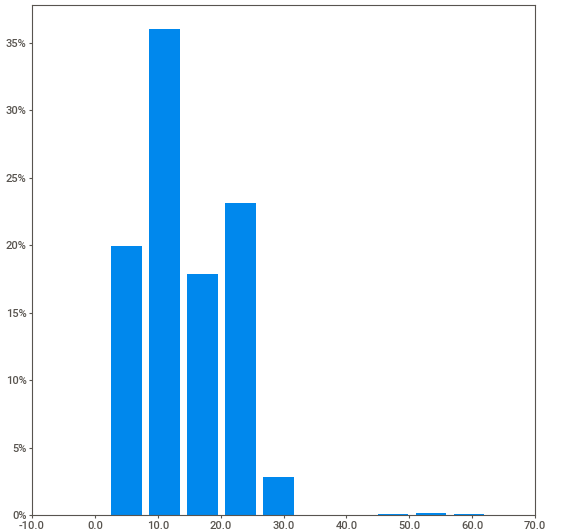
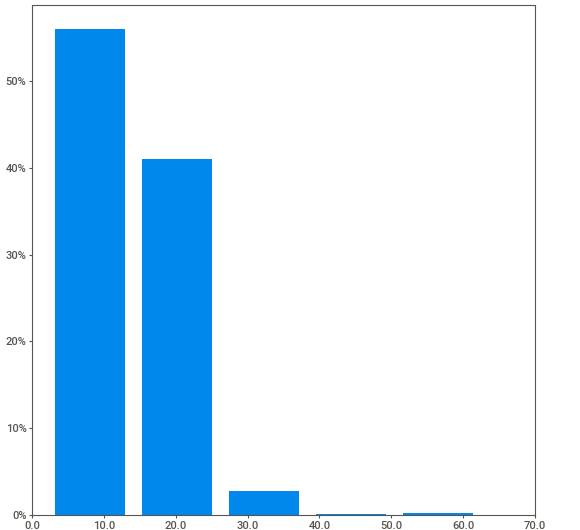
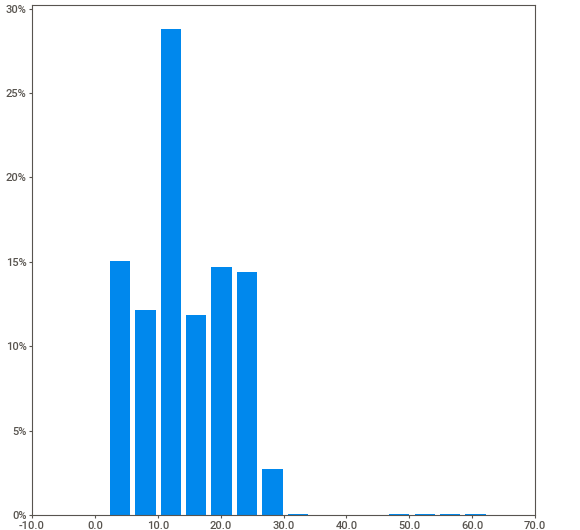
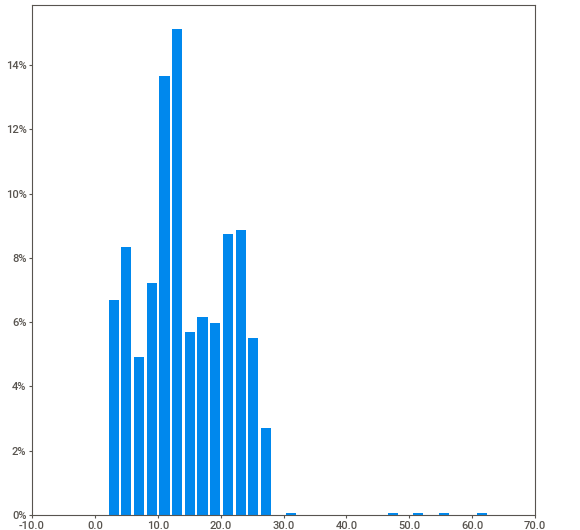
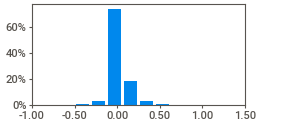
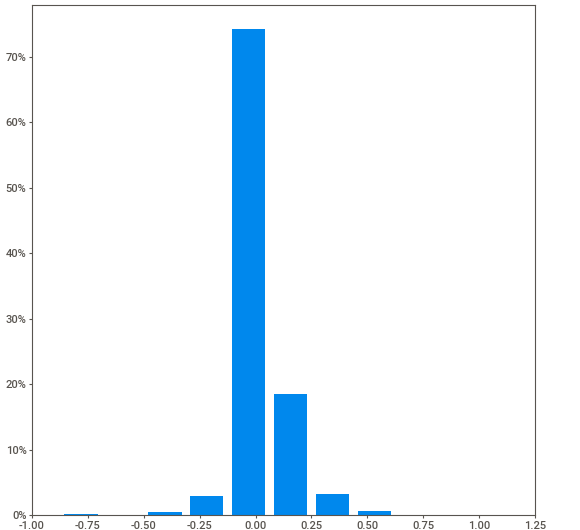
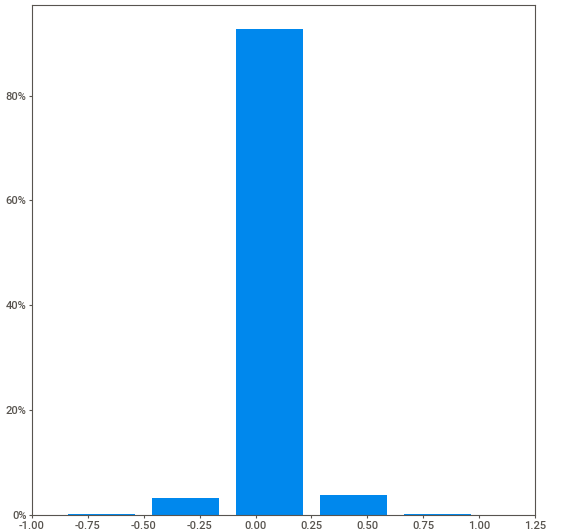
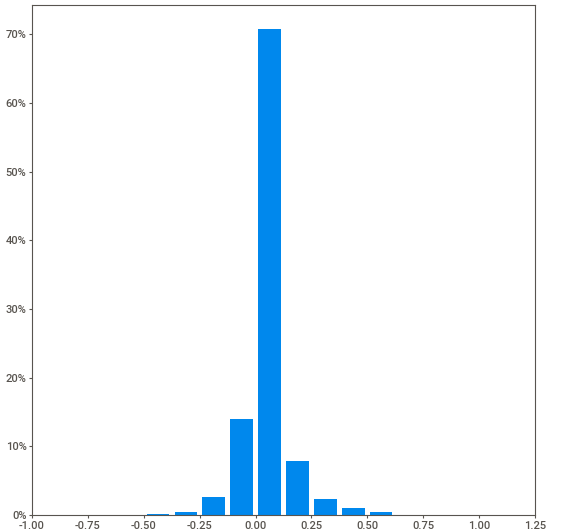
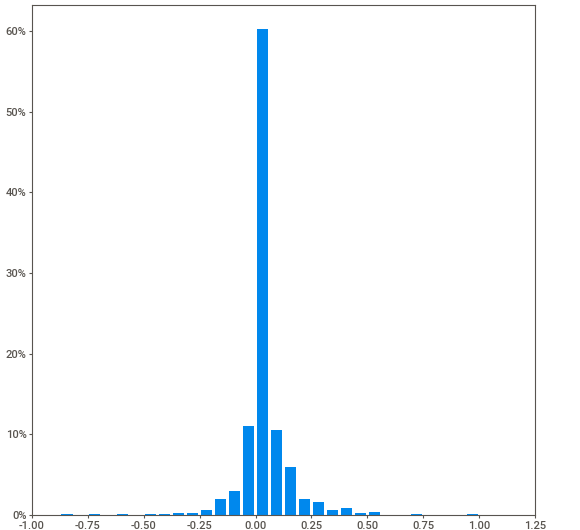
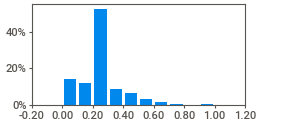
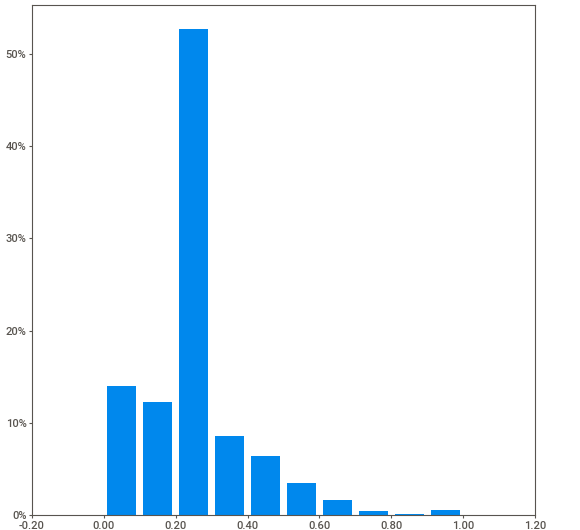
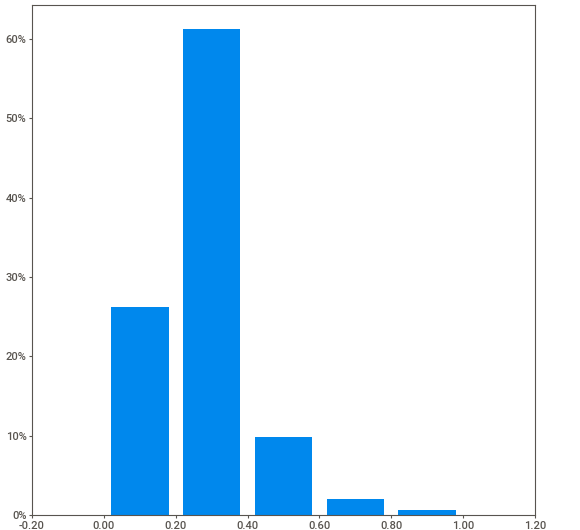
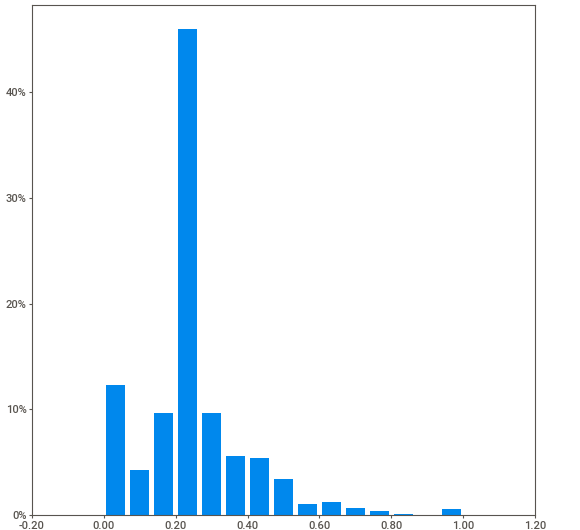
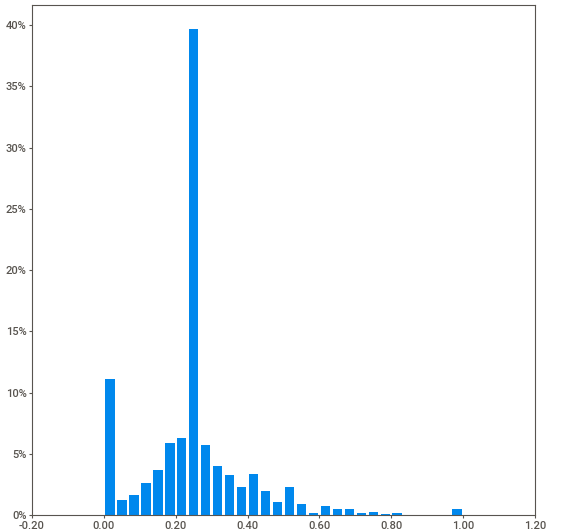
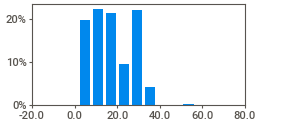
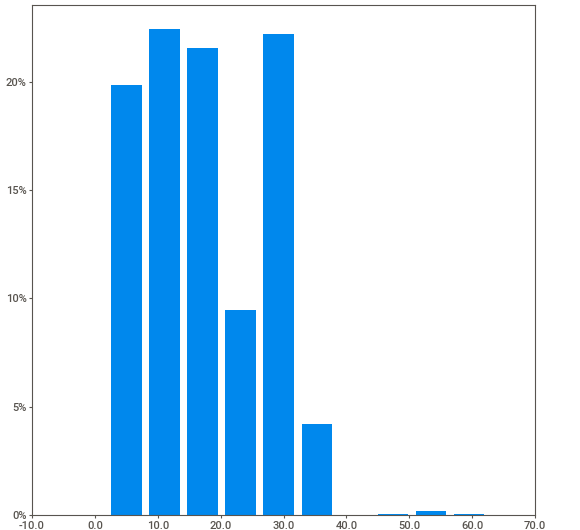
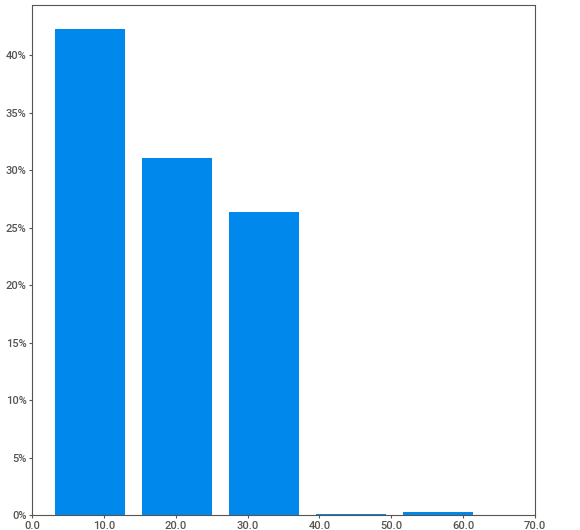
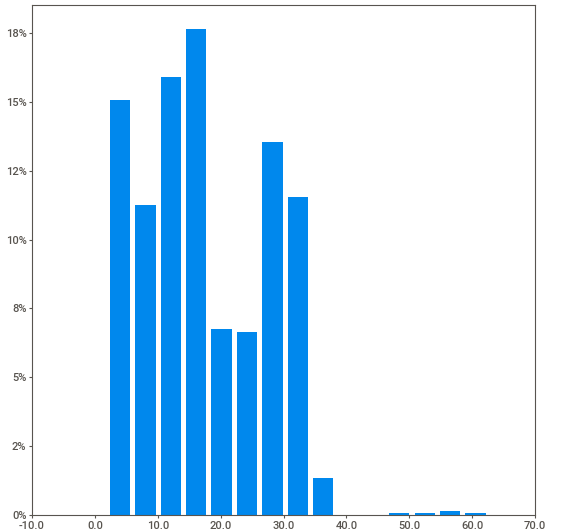
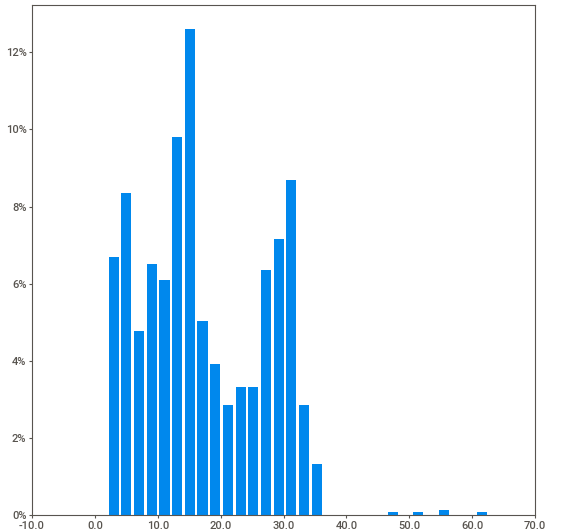
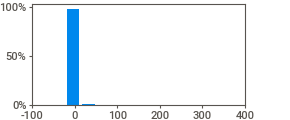
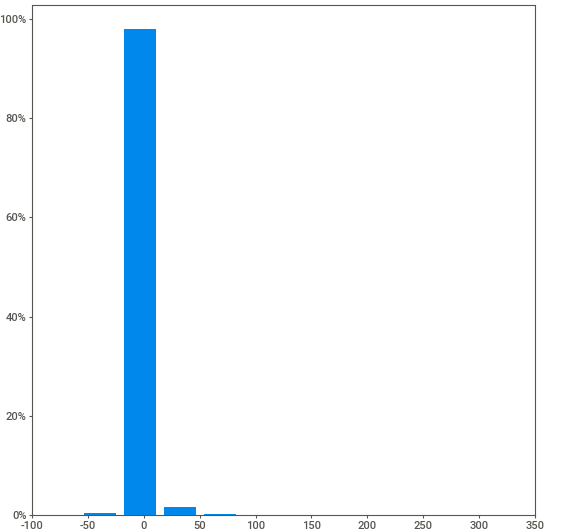
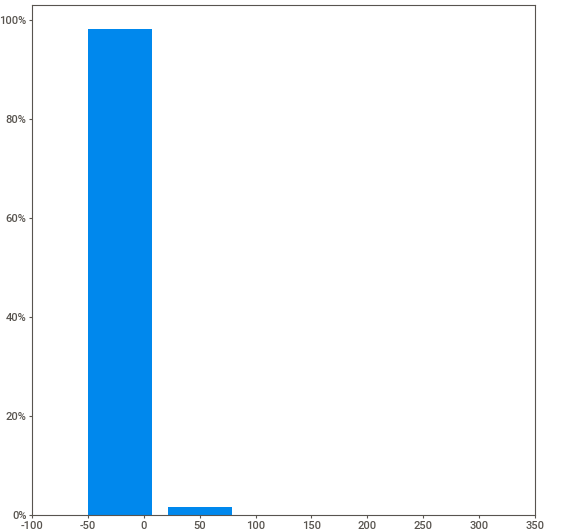
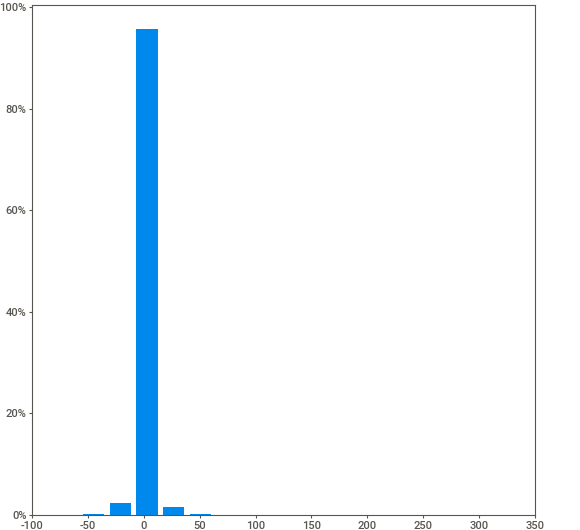
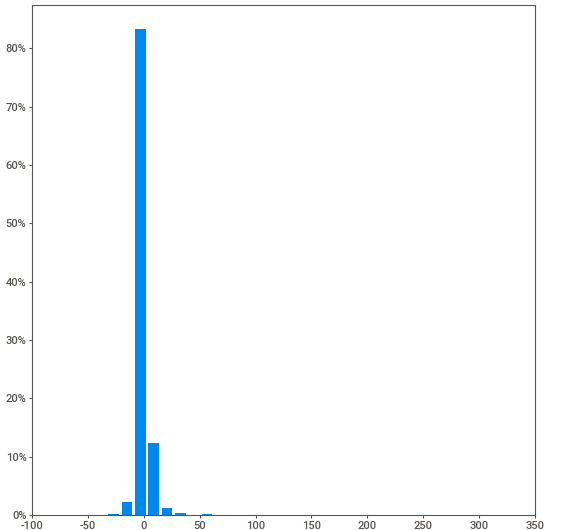
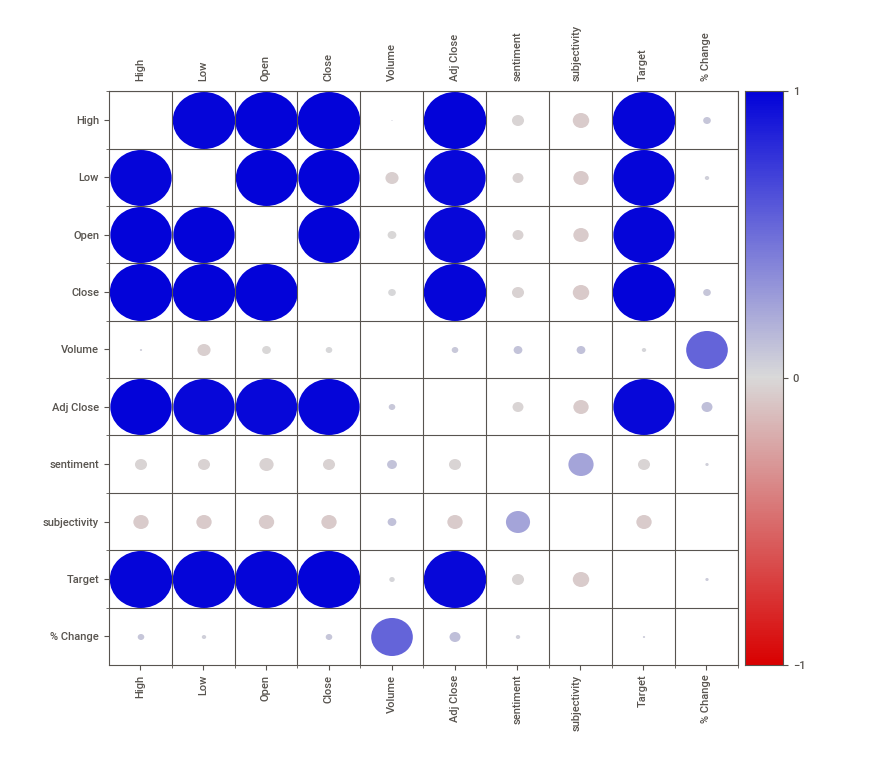
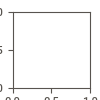

In [36]:
my_report = sv.analyze(df)
my_report.show_notebook(w='100%')

In [37]:
import plotly.express as px
fig = px.bar(df, y=df['sentiment'], x=df['Date'])
fig.show()

In [38]:
fig = px.bar(df.iloc[1144:], y='% Change', x='Date', labels={'% Change', 'Date'})
fig.show()

In [39]:
fig = px.bar(df.iloc[1144:], y='sentiment', x='Date', labels={'sentiment', 'Date'})
fig.show()

In [42]:
fig = px.scatter(df, y=df['subjectivity'], x=df['sentiment'])
fig.show()

In [44]:
#Percent change vs 
fig = px.scatter(df, y=df['% Change'], x=df['sentiment'])
fig.show()

In [ ]:
fig = px.scatter(df, y=df['Close'], x=df['sentiment'])
fig.show()

In [46]:
df1 = df
df1.head()

Date       High    Low       Open      Close    Volume  Adj Close  \
0 2015-06-11  28.809999  28.02  28.070000  28.570000  158300.0  21.339277   
1 2015-06-12  28.549999  28.15  28.420000  28.469999  160800.0  21.264591   
2 2015-06-15  28.930000  27.90  28.219999  28.870001  445900.0  21.563354   
3 2015-06-16  28.879999  28.42  28.850000  28.469999  230200.0  21.264591   
4 2015-06-17  28.799999  28.01  28.540001  28.010000  210500.0  20.921007   

   sentiment  subjectivity     Target  % Change  
0   0.040858       0.24843  28.469999  1.240257  
1   0.040858       0.24843  28.870001 -0.350019  
2   0.040858       0.24843  28.469999  1.404993  
3   0.040858       0.24843  28.010000 -1.385527  
4   0.040858       0.24843  29.580000 -1.615733

In [47]:
df1.to_csv('cleaned_df.csv')